In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchaudio
import numpy as np
import scipy
import sklearn
import pandas as pd
import PIL
import matplotlib
import tokenizers
import datasets
import transformers
import matplotlib.pyplot as plt
from collections import Counter
import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split


# Data exploration

Here we explore each feature column and comment on how we are going to preprocess each one and what we might consider doing in the future. We have a total of 140700 samples. The last feature is the label depression which we will train on.

## Loading the dataset

In [3]:
# Load the datasets
data_file = 'data/train.csv'
test_file = 'data/test.csv'

data = pd.read_csv(data_file)
test = pd.read_csv(test_file)

print(f"Samples in training set {data.shape[0]}")
print(f"Samples in test set: {test.shape[0]}")

Samples in training set 140700
Samples in test set: 93800


# id Column

In [4]:
# Print examples of the 'id' column
print("Examples of 'id' column:")
print(data["id"].head())

print("")

print("We have " ,data["id"].count()," amount of samples")

Examples of 'id' column:
0    0
1    1
2    2
3    3
4    4
Name: id, dtype: int64

We have  140700  amount of samples


We will drop the id column since there is no correlation between this and the label.

## Name column

In [5]:
# Count occurrences of each unique name
name_counts = data["Name"].value_counts()

# Print results
print("Unique names sorted by count (most to least):")
for name, count in name_counts.items():
    print(f"{name}: {count}")

print(f"Total unique names: {len(name_counts)}")


Unique names sorted by count (most to least):
Rohan: 3178
Aarav: 2336
Rupak: 2176
Aaradhya: 2045
Anvi: 2035
Raghavendra: 1877
Vani: 1657
Tushar: 1596
Ritvik: 1589
Shiv: 1568
Riya: 1548
Rashi: 1547
Raunak: 1524
Anand: 1486
Ishaani: 1477
Ansh: 1423
Vidya: 1408
Ritika: 1313
Anushka: 1279
Sanya: 1272
Aarush: 1266
Aariv: 1254
Abhishek: 1252
Rupal: 1234
Harsha: 1230
Harsh: 1156
Vikram: 1154
Shivam: 1146
Raghav: 1120
Armaan: 1116
Prachi: 1104
Ivaan: 1090
Ayaan: 1090
Siddhesh: 1090
Ira: 1061
Prisha: 1055
Rahil: 1051
Rishi: 1040
Ritik: 1033
Pratham: 1023
Aniket: 1023
Chhavi: 1003
Vibha: 974
Vivan: 963
Aishwarya: 962
Gauri: 959
Nikita: 951
Naina: 946
Veda: 940
Arav: 925
Vidhi: 913
Jiya: 912
Advait: 910
Krishna: 875
Vedant: 872
Ayush: 869
Aditi: 851
Shaurya: 848
Kashish: 845
Gagan: 842
Eshita: 831
Pratyush: 816
Ila: 799
Simran: 790
Aadhya: 787
Shreya: 784
Rudransh: 776
Garima: 769
Yashvi: 767
Anjali: 757
Vihaan: 744
Keshav: 737
Yuvraj: 730
Ishan: 714
Tanisha: 713
Harshil: 712
Sanket: 710
Rajat: 7

We thought about dropping the name column since we thought that this may not have any correlation to the label. But we realised that there might be a correlation, so we decided to keep it. The correlation being that for example having a "unattractive" name can affect your life in a bad way. 


For pre-processing this we will to give a value of how unique it is in the dataset, so for now we change the name with how frequent it is.


Things to consider:

Find a way to "rate" each name instead of how frequent the name is. Impute or change wrong names to missing name.

## Gender

In [6]:
# Print examples of the 'Name' column
print("Examples of 'Name' column:")
print(data["Gender"].head())

print("")

print("Number of unique genders:", data["Gender"].nunique())

Examples of 'Name' column:
0    Female
1      Male
2      Male
3      Male
4    Female
Name: Gender, dtype: object

Number of unique genders: 2


We will just encode male to 1 and female to 0.

## Age

In [7]:
print("Examples of 'Age' column:")
print(data["Age"].head())

print("")

print("Number of unique ages:", data["Age"].nunique())

Examples of 'Age' column:
0    49.0
1    26.0
2    33.0
3    22.0
4    30.0
Name: Age, dtype: float64

Number of unique ages: 43


We will only change the number from float to integer.

## City

In [8]:
print("Examples of 'City' column:")
print(data["City"].head())

print("")

print("Number of unique cities:", data["Age"].nunique())

Examples of 'City' column:
0         Ludhiana
1         Varanasi
2    Visakhapatnam
3           Mumbai
4           Kanpur
Name: City, dtype: object

Number of unique cities: 43


In [9]:
# Count occurrences of each unique city
city_counts = data["City"].value_counts()

# Find first occurrence index for each unique city
first_occurrence = data.groupby("City").apply(lambda x: x.index[0])

# Sort cities by count in descending order
sorted_cities = city_counts.index  # Cities sorted by count (default sorting from most to least)

count = 0
# Print results
print("Unique cities sorted by count (most to least):")
for city in sorted_cities:
    if city_counts[city] > 0:
        count += 1
        print(f"{city}: First Index = {first_occurrence[city]}, Count = {city_counts[city]}")

print(f"Total unique cities: {count}")


Unique cities sorted by count (most to least):
Kalyan: First Index = 36, Count = 6591
Patna: First Index = 9, Count = 5924
Vasai-Virar: First Index = 49, Count = 5765
Kolkata: First Index = 28, Count = 5689
Ahmedabad: First Index = 5, Count = 5613
Meerut: First Index = 17, Count = 5528
Ludhiana: First Index = 0, Count = 5226
Pune: First Index = 13, Count = 5210
Rajkot: First Index = 10, Count = 5207
Visakhapatnam: First Index = 2, Count = 5176
Srinagar: First Index = 26, Count = 5074
Mumbai: First Index = 3, Count = 4966
Indore: First Index = 189, Count = 4872
Agra: First Index = 18, Count = 4684
Surat: First Index = 20, Count = 4636
Varanasi: First Index = 1, Count = 4606
Vadodara: First Index = 43, Count = 4568
Hyderabad: First Index = 23, Count = 4496
Kanpur: First Index = 4, Count = 4398
Jaipur: First Index = 12, Count = 4328
Thane: First Index = 6, Count = 4289
Lucknow: First Index = 16, Count = 4280
Nagpur: First Index = 37, Count = 4209
Bangalore: First Index = 8, Count = 4123
C

C:\Users\elias\AppData\Local\Temp\ipykernel_12584\1198885951.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  first_occurrence = data.groupby("City").apply(lambda x: x.index[0])


We found population, density, literacy and sex ratio for each major city in our dataset. We then merged this in our data and removed city column. For the minor cities or the wrongly written cities we took the average of the other columns.


To consider:

We should consider adjusting the imputing of the minor and wrongly written cities to for example lower than average.

# Working Professional or Student

In [10]:
print("Examples of 'Working Professional or Student' column:")
print(data["Working Professional or Student"].head())

print("")

print("Number of unique Working Professional or Student:", data["Working Professional or Student"].nunique())

Examples of 'Working Professional or Student' column:
0    Working Professional
1    Working Professional
2                 Student
3    Working Professional
4    Working Professional
Name: Working Professional or Student, dtype: object

Number of unique Working Professional or Student: 2


In this column we will change "working professional" to 0 and "student" to 1.

# Profession

In [11]:
print("Examples of 'Profession' column:")
print(data["Profession"].head())
print("")
print("NaN is student:")
print(data["Profession"][2])
print(data["Working Professional or Student"][2])

print("")

print("Number of unique Profession:", data["Profession"].nunique())



Examples of 'Profession' column:
0                Chef
1             Teacher
2                 NaN
3             Teacher
4    Business Analyst
Name: Profession, dtype: object

NaN is student:
nan
Student

Number of unique Profession: 64


There are occurences of NaN in this column, this happens when the sample is a student. We find it reasonable to insert "Student" in those slots. there are also occurences of NaN on samples that are not students, here we will insert "Missing Profession"

# Academic Pressure

In [12]:
print("Examples of 'Academic pressure' column:")
print(data["Academic Pressure"].head())

print("")

print("Number of unique Academic pressures:", data["Academic Pressure"].nunique())

Examples of 'Academic pressure' column:
0    NaN
1    NaN
2    5.0
3    NaN
4    NaN
Name: Academic Pressure, dtype: float64

Number of unique Academic pressures: 5


For the "Academic Pressure" column we want to replace NaN with zeros.
We are aslo considering merging this feature with work pressure, since they complete eachother. but for now we will have it like this and maybe change it for improving the model later.

# Work pressure

In [13]:
print("Examples of 'Work Pressure' column:")
print(data["Work Pressure"].head())

print("")

print("Number of unique Work Pressure:", data["Work Pressure"].unique())

Examples of 'Work Pressure' column:
0    5.0
1    4.0
2    NaN
3    5.0
4    1.0
Name: Work Pressure, dtype: float64

Number of unique Work Pressure: [ 5.  4. nan  1.  2.  3.]


We assume that a lower number means less work pressure, therefore We will change Nan to 0 because it is the students that has NaN on Work Pressure

# CGPA

In [14]:
print("Examples of 'CGPA' column:")
print(data["CGPA"].head())
print(data["CGPA"].mean())

Examples of 'CGPA' column:
0     NaN
1     NaN
2    8.97
3     NaN
4     NaN
Name: CGPA, dtype: float64
7.658636192558608


We consider changing the NaN slots to the average of the dataset, which is 7.66

# Study Satisfaction and Job Satisfaction (Satisfaction)

In [15]:
print("Examples of 'Study Satisfaction' and 'Job Satisfaction' column:")
print(data["Study Satisfaction"].head())
print(data["Job Satisfaction"].head())

Examples of 'Study Satisfaction' and 'Job Satisfaction' column:
0    NaN
1    NaN
2    2.0
3    NaN
4    NaN
Name: Study Satisfaction, dtype: float64
0    2.0
1    3.0
2    NaN
3    1.0
4    1.0
Name: Job Satisfaction, dtype: float64


You can tell that when there is missing a value in the study satisfaction column, there is a value in the same sample but on the job satisfaction problem. these two columns complete eachother, so we will combine these two columns into one "satisfaction" column.

# Sleep Duration

In [16]:
sleep_counts = data["Sleep Duration"].value_counts()

print("Unique sleep sorted by count (most to least):")
for e, (duration, count) in enumerate(sleep_counts.items()):
    print(duration, count)
    if e == 6:
        break

Unique sleep sorted by count (most to least):
Less than 5 hours 38784
7-8 hours 36969
More than 8 hours 32726
5-6 hours 32142
3-4 hours 12
6-7 hours 8
4-5 hours 7


This one looks a bit tricky. since there are so few occurnces of other than the four most common inputs in this feature, we will change the numbers to a scale from 1 to 4, where 1 is "less than 5 hours" all the way to 4 which is "more than 8 hours". all the others will be set to 1.

# Dietary Habits

In [17]:
diet_counts = data["Dietary Habits"].value_counts()

print("Unique sleep sorted by count (most to least):")
for e, (diet, count) in enumerate(diet_counts.items()):
    print(diet, count)
    if e == 6:
        break

Unique sleep sorted by count (most to least):
Moderate 49705
Unhealthy 46227
Healthy 44741
Yes 2
No 2
More Healthy 2
No Healthy 1


* Healthy -> 2
* Moderate -> 1
* Unhealthy -> 0
* The rest -> 1

# Degree

In [18]:
degree_counts = data["Degree"].value_counts()
print(data["Degree"].nunique())

print("Unique sleep sorted by count (most to least):")
for e, (degree, count) in enumerate(degree_counts.items()):
    print(degree, count)
    if e == 10:
        break

115
Unique sleep sorted by count (most to least):
Class 12 14729
B.Ed 11691
B.Arch 8742
B.Com 8113
B.Pharm 5856
BCA 5739
M.Ed 5668
MCA 5234
BBA 5030
BSc 5027
MSc 4879


This one is particularly difficult because there are 115 unique degrees and there are not just a few degrees that covers the majority of the dataset either as the case is in the dietary habit feature. Our approach here is to somehow categorize the different degrees into bachelor, master, doctrine etc. and then give each of them a number from -1 to 4 based on the rank of the degree, going from "other" (which is the case where we can't define what degree it is) to professional.

# Have you ever had suicidal thoughts ?

In [19]:
print("Examples of 'Have you ever had suicidal thoughts ?' column:")
print(data["Have you ever had suicidal thoughts ?"].head())

print("")

print("Number of unique Have you ever had suicidal thoughts ?:", data["Have you ever had suicidal thoughts ?"].nunique())

Examples of 'Have you ever had suicidal thoughts ?' column:
0     No
1    Yes
2    Yes
3    Yes
4    Yes
Name: Have you ever had suicidal thoughts ?, dtype: object

Number of unique Have you ever had suicidal thoughts ?: 2


We will also change this column to binary no / yes to 0 / 1

# Work Study Hours (No prerocessing needed here)

In [20]:
ws_counts = data["Work/Study Hours"].value_counts()
print(data["Work/Study Hours"].nunique())

print("Unique Work/Study Hours sorted by count (most to least):")
for e, (ws, count) in enumerate(ws_counts.items()):
    print(ws, count)
    if e == 20:
        break

13
Unique Work/Study Hours sorted by count (most to least):
10.0 14199
11.0 12832
9.0 12711
0.0 12066
12.0 11409
2.0 10595
6.0 10432
7.0 9872
1.0 9802
3.0 9474
5.0 9337
4.0 9065
8.0 8906


# Financial Stress

In [21]:
finans_count = data["Financial Stress"].value_counts()
print(data["Financial Stress"].nunique())

print("Unique sleep sorted by count (most to least):")
for e, (fn, count) in enumerate(finans_count.items()):
    print(fn, count)
    if e == 10:
        break

5
Unique sleep sorted by count (most to least):
2.0 31451
5.0 28279
4.0 27765
1.0 27211
3.0 25990


Has a few missing values, we will impute the mean in these.

# Family History of Mental Illness

In [22]:
print("Examples of 'Family History of Mental Illness' column:")
print(data["Family History of Mental Illness"].head())

print("")

print("Number of unique Family History of Mental Illnesses:", data["Family History of Mental Illness"].nunique())

Examples of 'Family History of Mental Illness' column:
0     No
1     No
2     No
3    Yes
4    Yes
Name: Family History of Mental Illness, dtype: object

Number of unique Family History of Mental Illnesses: 2


For this column we will change yes and no to 1 and 0

# Depression - The label
Plotting the distribution of the labels

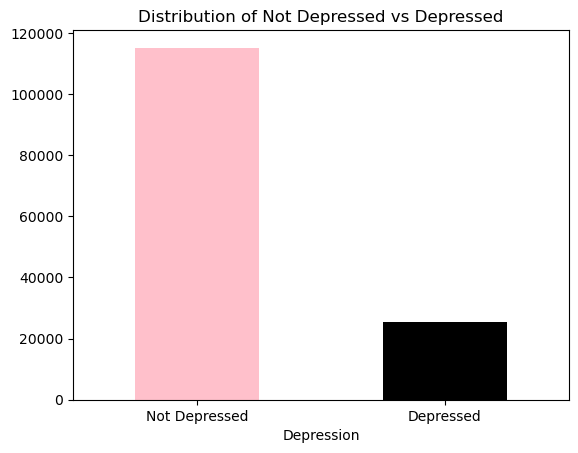

In [23]:
target_counts = data['Depression'].value_counts()
target_counts.plot(kind='bar', color=['pink', 'black'])
plt.xticks(ticks=[0, 1], labels=['Not Depressed', 'Depressed'], rotation=0)
plt.title('Distribution of Not Depressed vs Depressed')
plt.show()

You can tell that there is a significant imbalance between depressed and not depressed. 

# Pre-processing

Dropping the Id column

In [24]:
def dropId(data):
    data = data.drop(columns=["id"])
    return data

Encoding the name column, Replacing each name with its frequency in the dataset

In [25]:
def name_freq(data):
    data["Name"] = data["Name"].map(data["Name"].value_counts())
    return data

Encoding gender column 0/1

In [26]:
def gender_encode(data):
    data["Gender"] = data["Gender"].map({"Female": 0, "Male": 1 })
    return data

Age, changing the type

In [27]:
def age_integer(data):
    data["Age"] = data["Age"].astype(int)
    return data

Academic Preessure, inserting 0 in the empty slots

In [28]:
def academic_pressure(data):
    data["Academic Pressure"] = np.where(
        data["Academic Pressure"].isnull(), 0,
        data["Academic Pressure"]
    )
    return data

Family History of Mental Illnes. -> 0/1

In [29]:
def family_mental_illness(data):
    data["Family History of Mental Illness"] = np.where(
        data["Family History of Mental Illness"] == "No", 0,
        np.where(
            data["Family History of Mental Illness"] == "Yes", 1,
            data["Family History of Mental Illness"]
        )
    )

    # Convert to integer type
    data["Family History of Mental Illness"] = data["Family History of Mental Illness"].astype(int)
    
    return data

Have you ever had suicidal thoughts? -> 0/1

In [30]:
def suicidal_thoughts(data):
    data["Have you ever had suicidal thoughts ?"] = np.where(
        data["Have you ever had suicidal thoughts ?"] == "No", 0,
        np.where(
            data["Have you ever had suicidal thoughts ?"] == "Yes", 1,
            data["Have you ever had suicidal thoughts ?"]
        )
    )

    data["Have you ever had suicidal thoughts ?"] = data["Have you ever had suicidal thoughts ?"].astype(int)
    return data

Financial stress

In [31]:
def financial_stress(data):
    data["Financial Stress"] = np.where(
        data["Financial Stress"].isnull(), round(data["Financial Stress"].mean()), data["Financial Stress"]
    )
    return data

Working Professional or Student. -> 0/1

In [32]:
def working_or_student(data):
    data["Working Professional or Student"] = np.where(
        data["Working Professional or Student"] == "Working Professional", 0,
        np.where(
            data["Working Professional or Student"] == "Student", 1,
            data["Working Professional or Student"]
        )
    )       

    # Convert to integer type
    data["Working Professional or Student"] = data["Working Professional or Student"].astype(int)
    
    return data

Profession. Inserting Student in the empty slots if the sample is a student and missing profession if it is empty and the sample is not a student. also inserting "Missing Profession" in the professions that has less than 10 occurrences in the dataset because the majority of these are wrong information.

In [33]:
def profession(data):
    # Count occurrences of each profession
    profession_counts = data["Profession"].value_counts()
    
    # Update the "Profession" column
    data["Profession"] = np.where(
        data["Profession"].isnull() & (data["Working Professional or Student"] == 1),
        "Student",
        np.where(
            data["Profession"].isnull() & (data["Working Professional or Student"] == 0), 
            "Missing Profession", 
            np.where(
                data["Profession"].map(profession_counts) < 6,  # If occurrence < 10, set to "Missing Profession"
                "Missing Profession",
                data["Profession"]
            )
        )
    )
    return data


Categorizing Professions and giving each category a number. the number is a rating from 0 to 10 on how happy people are in given categories. We used chatGPT to rate them based on different logical points. see professions_mapping dictionary for description of the ratings.

In [34]:
def categorize_profession(profession):
    if pd.isna(profession) or "missing" in profession.lower():
        return "Unknown"
    
    profession = profession.lower().strip()

    # Technology
    tech_keywords = ["software", "data scientist", "ux/ui", "developer", "engineer"]
    if any(keyword in profession for keyword in tech_keywords):
        return "Technology"

    # Finance
    finance_keywords = ["accountant", "financial", "investment", "banker", "analyst"]
    if any(keyword in profession for keyword in finance_keywords):
        return "Finance"

    # Healthcare
    healthcare_keywords = ["doctor", "pharmacist", "dentist", "nurse"]
    if any(keyword in profession for keyword in healthcare_keywords):
        return "Healthcare"

    # Education
    education_keywords = ["teacher", "professor", "educational"]
    if any(keyword in profession for keyword in education_keywords):
        return "Education"

    # Engineering
    engineering_keywords = ["civil engineer", "mechanical engineer", "architect"]
    if any(keyword in profession for keyword in engineering_keywords):
        return "Engineering"

    # Marketing & Sales
    marketing_keywords = ["marketing", "sales", "digital marketer", "content writer"]
    if any(keyword in profession for keyword in marketing_keywords):
        return "Marketing/Sales"

    # Trade & Manual Work
    trade_keywords = ["electrician", "plumber", "chef", "mechanic"]
    if any(keyword in profession for keyword in trade_keywords):
        return "Trade"

    # Legal
    legal_keywords = ["lawyer", "judge", "legal"]
    if any(keyword in profession for keyword in legal_keywords):
        return "Legal"

    # Consulting
    consulting_keywords = ["consultant", "business analyst"]
    if any(keyword in profession for keyword in consulting_keywords):
        return "Consulting"

    # Other / Unknown
    return "Other"

def Prefession_categorization(data):
    # Apply categorization
    data["Profession_Category"] = data["Profession"].apply(categorize_profession)

    # Encoding Options

    ## Option 1: Ordinal Encoding (useful if there's a natural order)
    profession_mapping = {
    "Unknown": 0,           # No data on job satisfaction
    "Other": 4,             # Mixed bag, depends on the job
    "Trade": 6,             # Skilled trades often provide satisfaction, but physically demanding
    "Marketing/Sales": 5,   # High variability, stressful but rewarding
    "Consulting": 5,        # High pay but often high stress & long hours
    "Education": 7,         # Fulfilling, but pay can be low and stress can be high
    "Finance": 6,           # High pay, but long hours and stress
    "Engineering": 7,       # Good pay, problem-solving, but deadlines can be stressful
    "Healthcare": 6,        # Rewarding but high stress and burnout risk
    "Legal": 5,             # High salary, but stressful and demanding
    "Technology": 8         # High salary, flexibility, remote work options
}


    data["Profession_Encoded"] = data["Profession_Category"].map(profession_mapping)

    data["Profession"] = data["Profession_Encoded"]

    data = data.drop(columns=["Profession_Encoded", "Profession_Category"])
    return data
    ## Option 2: One-Hot Encoding (better for categorical data)
    # data = pd.get_dummies(data, columns=["Profession_Category"], prefix="Profession")


Work Pressure

In [35]:
def work_pressure(data):
    data["Work Pressure"] = np.where(
        data["Work Pressure"].isnull(), 0.0, data["Work Pressure"]
    )
    return data

CGPA

In [36]:
def cgpa(data):
    data["CGPA"] = np.where(
        data["CGPA"].isnull(), round(data["CGPA"].mean(), 2), data["CGPA"]
    )
    return data

Study- and Job Satisfaction

In [37]:
def satisfaction(data):
    satisfaction = np.where(
        data["Study Satisfaction"].notnull(), data["Study Satisfaction"], np.where(
            data["Job Satisfaction"].notnull(), data["Job Satisfaction"], 0
        )
    )
    data["Job Satisfaction"] = satisfaction
    data = data.drop(columns="Study Satisfaction")
    data.rename(columns={"Job Satisfaction": "Satisfaction"}, inplace=True)
    return data

Sleep Duration

In [38]:
def sleep_duration(data):
    data["Sleep Duration"] = np.where(
        data["Sleep Duration"] == "Less than 5 hours", 1, np.where(
            data["Sleep Duration"] == "5-6 hours", 2, np.where(
                data["Sleep Duration"] == "7-8 hours", 3, np.where(
                    data["Sleep Duration"] == "More than 8 hours", 4, 1
                )
            )
        )
    )
    return data

Dietary Habits

In [39]:
def diet(data):
    data["Dietary Habits"] = np.where(
        data["Dietary Habits"] == "Healthy", 2, np.where(
            data["Dietary Habits"] == "Moderate", 1, np.where(
                data["Dietary Habits"] == "Unhealthy", 0, 1
            )
        )
    )
    return data

In [40]:
def categorize_degree(degree):

    """
    Categorizes the differnet degrees into Schoo, Bachelors, Masters, Doctrate, professional and other
    """
    
    degree = str(degree).strip().lower()

    # School-Level
    if "class 11" in degree or "class 12" in degree:
        return "School"

    # Bachelor's Degrees
    bachelor_keywords = ["b.", "b ", "bachelor", "bcom", "bsc", "btech", "be", "bba", "bca", "ba", "b.ed", "b.arch"]
    if any(keyword in degree for keyword in bachelor_keywords):
        return "Bachelors"

    # Master's Degrees
    master_keywords = ["m.", "m ", "master", "mba", "mcom", "msc", "mtech", "me", "mca", "m.ed", "mpharm", "m.arch"]
    if any(keyword in degree for keyword in master_keywords):
        return "Masters"

    # Doctoral Degrees
    if "phd" in degree:
        return "Doctorate"

    # Professional Degrees
    professional_keywords = ["mbbs", "md", "llb", "llm"]
    if any(keyword in degree for keyword in professional_keywords):
        return "Professional"

    # Unknown / Noisy Data
    return "Other"

def degree(data):
    
    # Apply categorization
    data["Degree"] = data["Degree"].apply(categorize_degree)


    # Define an ordinal mapping
    degree_mapping = {
        "School": 1,
        "Bachelors": 2,
        "Masters": 3,
        "Professional": 4,
        "Doctorate": 5,
        "Other": 0  # Keep 'Other' at the highest level or remove it depending on the approach
    }

    # Apply mapping
    data["Degree"] = data["Degree"].map(degree_mapping)

    return data 



City

In [41]:
# Load city data
city_data_path = "./Data/indian_cities_data.csv"
df_cities = pd.read_csv(city_data_path)

def city_one_hot(data):
    # Find the index of the "City" column
    city_index = data.columns.get_loc("City")

    # Merge the data with city information, excluding "Main Language"
    merged_data = data.merge(df_cities.drop(columns=["Main Language"]), on="City", how="left")

    # Calculate the mean values for missing cities
    mean_values = merged_data[["Population", "Density (per km²)", "Literacy Rate (%)", "Sex Ratio"]].mean()

    # Replace NaN values with the mean of the respective column
    merged_data.fillna(mean_values, inplace=True)

    # Drop the original "City" column
    merged_data.drop(columns=["City"], inplace=True)

    # Reorder columns to place new city-related columns where "City" was
    city_columns = ["Population", "Density (per km²)", "Literacy Rate (%)", "Sex Ratio"]
    cols = merged_data.columns.tolist()

    # Move the new city-related columns to the correct index
    for col in reversed(city_columns):
        cols.insert(city_index, cols.pop(cols.index(col)))

    # Reorder the dataframe
    merged_data = merged_data[cols]

    return merged_data


Pre-processing function:

In [42]:
def pre_processing(data):

    data = dropId(data)
    data = name_freq(data)
    data = gender_encode(data)
    data = age_integer(data)
    data = academic_pressure(data)
    data = family_mental_illness(data)
    data = suicidal_thoughts(data)
    data = working_or_student(data)
    data = profession(data)
    data = work_pressure(data)
    data = cgpa(data)
    data = satisfaction(data)
    data = sleep_duration(data)
    data = diet(data)
    data = degree(data)
    data = Prefession_categorization(data)
    data = city_one_hot(data)
    data = financial_stress(data)
    return data

training_data = pre_processing(data)
test_data = pre_processing(test)
test_data.to_csv("test_data.csv", index=False)

In [43]:
print(training_data)

        Name  Gender  Age  Population  Density (per km²)  Literacy Rate (%)  \
0       2045       0   49   1618879.0             5200.0              85.77   
1        963       1   26   1198491.0             7300.0              79.27   
2        730       1   33   1728128.0             2500.0              81.79   
3        730       1   22  12442373.0            20482.0              89.73   
4        499       0   30   2765348.0             6900.0              82.42   
...      ...     ...  ...         ...                ...                ...   
140695  1408       0   18   5577940.0            11000.0              89.62   
140696   237       0   41   6731790.0            10477.0              83.26   
140697   684       0   24   4496694.0            22000.0              86.31   
140698  1104       0   49   1180570.0             4000.0              69.15   
140699   382       1   27   1684222.0            17012.0              83.37   

        Sex Ratio  Working Professional or Student 

Splitting the dataset into Train and val, also extracting the labels.

In [44]:
def split_training_data(seed=0, train_size=0.8, data=training_data):
    np.random.seed(seed)
    X = data.drop(columns=["Depression"])   
    y = data["Depression"]
    X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=train_size, random_state=seed, stratify=y)
    return X_train, X_val, y_train, y_val

Normalizing data

In [45]:
from sklearn.preprocessing import MinMaxScaler

def normalize_dataset(train_data, test_data):
    # Identify binary columns (values only 0 or 1)
    binary_columns = [col for col in train_data.columns if train_data[col].dropna().isin([0, 1]).all()]
    
    # Identify continuous numerical columns (everything else)
    continuous_columns = [col for col in train_data.columns if col not in binary_columns]

    # Initialize MinMaxScaler
    scaler = MinMaxScaler()

    # Fit on training data only, then transform both training and test data
    train_data_scaled = train_data.copy()
    test_data_scaled = test_data.copy()

    train_data_scaled[continuous_columns] = scaler.fit_transform(train_data[continuous_columns])
    test_data_scaled[continuous_columns] = scaler.transform(test_data[continuous_columns])  # Only transform

    return train_data_scaled, test_data_scaled


Data:

In [46]:
# Normalize Training and Test Data
training_data, test_data = normalize_dataset(training_data, test_data)

# Check results
print(training_data.head())
print(test_data.head())



X_train, X_val, y_train, y_val = split_training_data(data=training_data)

       Name  Gender       Age  Population  Density (per km²)  \
0  0.643374       0  0.738095    0.028083           0.196787   
1  0.302801       1  0.190476    0.001148           0.297189   
2  0.229462       1  0.357143    0.035083           0.067699   
3  0.229462       1  0.095238    0.721570           0.927424   
4  0.156752       0  0.285714    0.101540           0.278065   

   Literacy Rate (%)  Sex Ratio  Working Professional or Student  Profession  \
0           0.729908   0.403433                                0       0.750   
1           0.444444   0.562232                                0       0.875   
2           0.555116   0.952790                                1       0.500   
3           0.903821   0.416309                                0       0.875   
4           0.582784   0.433476                                0       0.750   

   Academic Pressure  ...      CGPA  Satisfaction  Sleep Duration  \
0                0.0  ...  0.529175           0.4        1.000000

# Defining the base learners and training them

#### Specialized Base learners trained on depression = 0 and depression = 1 

In [47]:
import pandas as pd

# Assume X_train is your feature DataFrame and y_train is your label Series
# First, combine them into one DataFrame.
train_df = X_train.copy()
train_df['Depression'] = y_train

# For the depressed specialized dataset (aim for 95% depression = 1)
# 1. Take all depressed samples.
df_depr = train_df[train_df['Depression'] == 1]
# 2. For non-depressed samples, we need only enough to be 5% of the final set.
#    Let D be the number of depressed samples. Then the desired number of non-depressed
#    samples is (5/95)*D.
D = len(df_depr)
non_depr_count = int((5 / 95) * D)
df_non_depr = train_df[train_df['Depression'] == 0]
# Randomly sample the required non-depressed samples.
df_non_depr_sample = df_non_depr.sample(n=non_depr_count, random_state=42)

# Combine to form the depressed-enriched specialized dataset.
df_special_depr = pd.concat([df_depr, df_non_depr_sample])

# For the non-depressed specialized dataset (aim for 95% depression = 0)
# 1. Take all non-depressed samples.
df_non_depr = train_df[train_df['Depression'] == 0]
# 2. Compute the number of depressed samples needed to be 5% of this dataset.
ND = len(df_non_depr)
depr_count = int((5 / 95) * ND)
df_depr_sample = train_df[train_df['Depression'] == 1].sample(n=depr_count, random_state=42)

# Combine to form the non-depressed-enriched specialized dataset.
df_special_non_depr = pd.concat([df_non_depr, df_depr_sample])

# Now, separate features and labels for each specialized dataset.
X_special_depr = df_special_depr.drop(columns=['Depression'])
y_special_depr = df_special_depr['Depression']

X_special_non_depr = df_special_non_depr.drop(columns=['Depression'])
y_special_non_depr = df_special_non_depr['Depression']

# Optionally, print out the class distributions to verify the ratios:
print("Depressed specialized set class distribution:")
print(y_special_depr.value_counts(normalize=True))
# print(y_special_depr.value_counts())
print("\nNon-depressed specialized set class distribution:")
print(y_special_non_depr.value_counts(normalize=True))
# print(y_special_non_depr.value_counts())


Depressed specialized set class distribution:
Depression
1    0.950023
0    0.049977
Name: proportion, dtype: float64

Non-depressed specialized set class distribution:
Depression
0    0.950007
1    0.049993
Name: proportion, dtype: float64


In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Define parameter grids for each model type.
logistic_params = {'C': [0.01, 0.1, 1, 10]}
tree_params = {'max_depth': [None, 5, 10], 'min_samples_split': [2, 5, 10]}
rf_params = {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]}
xgb_params = {'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7], 'n_estimators': [100, 200]}
ada_params = {'n_estimators': [50, 100, 200], 'learning_rate': [0.5, 1.0, 1.5]}

# Create dictionaries to hold the specialized learners.
# We want 5 models for depression = 1 (depressed) and 5 for depression = 0 (non-depressed).

specialized_learners = {}

# --- For the Depressed Group (label == 1) ---
# Assume X_special_depr and y_special_depr are the enriched training data for depression=1.
# Logistic Regression specialized for depressed samples.
logistic_depr_grid = GridSearchCV(LogisticRegression(max_iter=1000), logistic_params, cv=5, scoring='accuracy')
logistic_depr_grid.fit(X_special_depr, y_special_depr)
specialized_learners["logistic_depr"] = logistic_depr_grid.best_estimator_
print("Trained logistic_depr with best parameters:", logistic_depr_grid.best_params_)

# Decision Tree specialized for depressed samples.
tree_depr_grid = GridSearchCV(DecisionTreeClassifier(), tree_params, cv=5, scoring='accuracy')
tree_depr_grid.fit(X_special_depr, y_special_depr)
specialized_learners["tree_depr"] = tree_depr_grid.best_estimator_
print("Trained tree_depr with best parameters:", tree_depr_grid.best_params_)

# Random Forest specialized for depressed samples.
rf_depr_grid = GridSearchCV(RandomForestClassifier(), rf_params, cv=5, scoring='accuracy')
rf_depr_grid.fit(X_special_depr, y_special_depr)
specialized_learners["rf_depr"] = rf_depr_grid.best_estimator_
print("Trained rf_depr with best parameters:", rf_depr_grid.best_params_)

# XGBoost specialized for depressed samples.
xgb_depr_grid = GridSearchCV(xgb.XGBClassifier(eval_metric='logloss'), xgb_params, cv=5, scoring='accuracy')
xgb_depr_grid.fit(X_special_depr, y_special_depr)
specialized_learners["xgb_depr"] = xgb_depr_grid.best_estimator_
print("Trained xgb_depr with best parameters:", xgb_depr_grid.best_params_)

# AdaBoost specialized for depressed samples.
ada_depr_grid = GridSearchCV(AdaBoostClassifier(algorithm='SAMME'), ada_params, cv=5, scoring='accuracy')
ada_depr_grid.fit(X_special_depr, y_special_depr)
specialized_learners["ada_depr"] = ada_depr_grid.best_estimator_
print("Trained ada_depr with best parameters:", ada_depr_grid.best_params_)

# --- For the Non-Depressed Group (label == 0) ---
# Assume X_special_non_depr and y_special_non_depr are the enriched training data for depression=0.
# Logistic Regression specialized for non-depressed samples.
logistic_non_depr_grid = GridSearchCV(LogisticRegression(max_iter=1000), logistic_params, cv=5, scoring='accuracy')
logistic_non_depr_grid.fit(X_special_non_depr, y_special_non_depr)
specialized_learners["logistic_nondepr"] = logistic_non_depr_grid.best_estimator_
print("Trained logistic_nondepr with best parameters:", logistic_non_depr_grid.best_params_)

# Decision Tree specialized for non-depressed samples.
tree_non_depr_grid = GridSearchCV(DecisionTreeClassifier(), tree_params, cv=5, scoring='accuracy')
tree_non_depr_grid.fit(X_special_non_depr, y_special_non_depr)
specialized_learners["tree_nondepr"] = tree_non_depr_grid.best_estimator_
print("Trained tree_nondepr with best parameters:", tree_non_depr_grid.best_params_)

# Random Forest specialized for non-depressed samples.
rf_non_depr_grid = GridSearchCV(RandomForestClassifier(), rf_params, cv=5, scoring='accuracy')
rf_non_depr_grid.fit(X_special_non_depr, y_special_non_depr)
specialized_learners["rf_nondepr"] = rf_non_depr_grid.best_estimator_
print("Trained rf_nondepr with best parameters:", rf_non_depr_grid.best_params_)

# XGBoost specialized for non-depressed samples.
xgb_non_depr_grid = GridSearchCV(xgb.XGBClassifier(eval_metric='logloss'), xgb_params, cv=5, scoring='accuracy')
xgb_non_depr_grid.fit(X_special_non_depr, y_special_non_depr)
specialized_learners["xgb_nondepr"] = xgb_non_depr_grid.best_estimator_
print("Trained xgb_nondepr with best parameters:", xgb_non_depr_grid.best_params_)

# AdaBoost specialized for non-depressed samples.
ada_non_depr_grid = GridSearchCV(AdaBoostClassifier(algorithm='SAMME'), ada_params, cv=5, scoring='accuracy')
ada_non_depr_grid.fit(X_special_non_depr, y_special_non_depr)
specialized_learners["ada_nondepr"] = ada_non_depr_grid.best_estimator_
print("Trained ada_nondepr with best parameters:", ada_non_depr_grid.best_params_)

print("\nTotal specialized base learners trained:", len(specialized_learners))


Trained logistic_depr with best parameters: {'C': 1}
Trained tree_depr with best parameters: {'max_depth': 5, 'min_samples_split': 2}
Trained rf_depr with best parameters: {'max_depth': None, 'n_estimators': 200}
Trained xgb_depr with best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}


c:\Users\elias\anaconda3\envs\INF367A\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\elias\anaconda3\envs\INF367A\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\elias\anaconda3\envs\INF367A\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\elias\anaconda3\envs\INF367A\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to ci

Trained ada_depr with best parameters: {'learning_rate': 0.5, 'n_estimators': 200}
Trained logistic_nondepr with best parameters: {'C': 0.1}
Trained tree_nondepr with best parameters: {'max_depth': 5, 'min_samples_split': 2}
Trained rf_nondepr with best parameters: {'max_depth': 20, 'n_estimators': 200}
Trained xgb_nondepr with best parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}


c:\Users\elias\anaconda3\envs\INF367A\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\elias\anaconda3\envs\INF367A\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\elias\anaconda3\envs\INF367A\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\elias\anaconda3\envs\INF367A\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to ci

Trained ada_nondepr with best parameters: {'learning_rate': 0.5, 'n_estimators': 200}

Total specialized base learners trained: 10


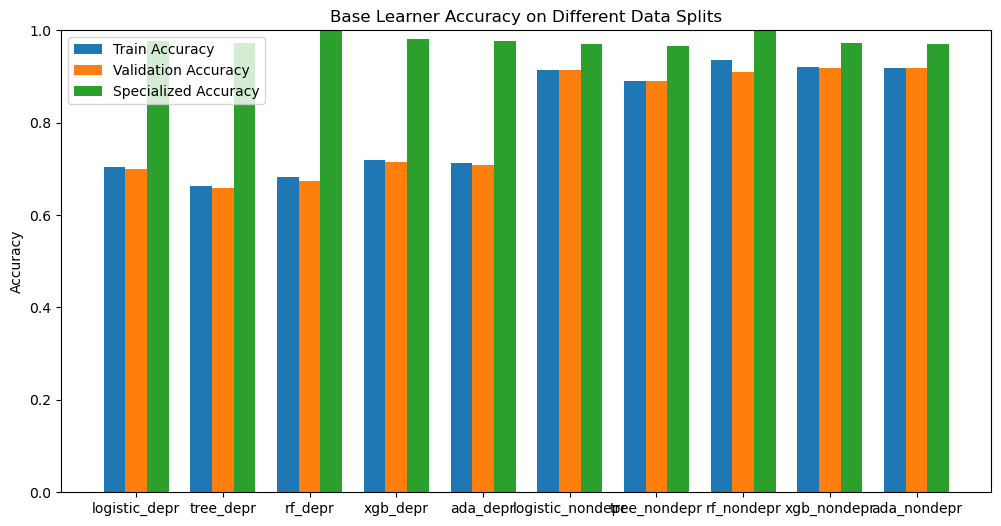

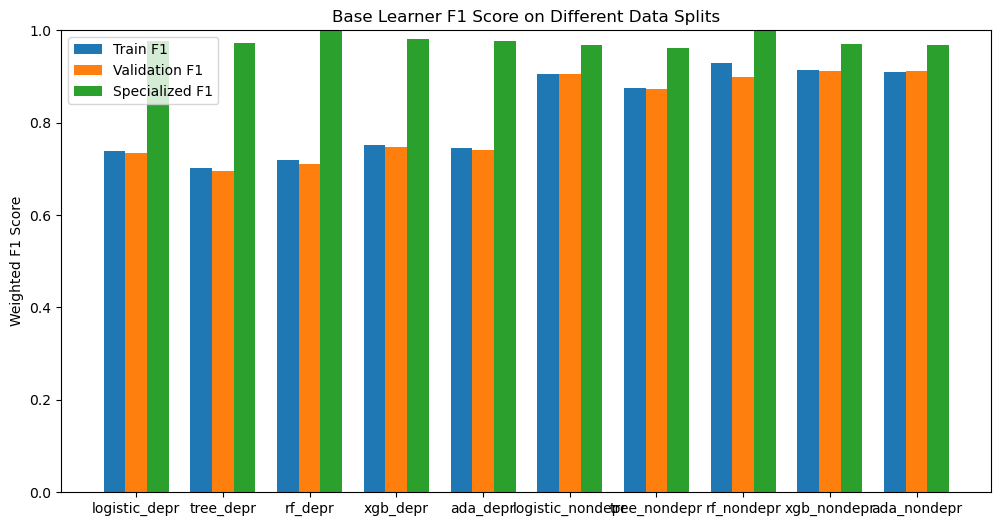

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

def evaluate_model(model, X, y):
    """
    Evaluates a given base learner on data (X, y).
    Returns accuracy, weighted F1 score, and confusion matrix.
    """
    # Get predicted class labels
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    cm = confusion_matrix(y, y_pred)
    return acc, f1, cm

# Create an empty dictionary to store evaluation results.
results = {}  # keys: base learner names; values: dict with metrics for each split

# Iterate over each specialized base learner.
for name, model in specialized_learners.items():
    results[name] = {}
    # Evaluate on overall training data.
    acc_train, f1_train, cm_train = evaluate_model(model, X_train, y_train)
    results[name]['train'] = {'accuracy': acc_train, 'f1': f1_train, 'cm': cm_train}
    
    # Evaluate on overall validation data.
    acc_val, f1_val, cm_val = evaluate_model(model, X_val, y_val)
    results[name]['val'] = {'accuracy': acc_val, 'f1': f1_val, 'cm': cm_val}
    
    # Evaluate on specialized data:
    # For learners specialized for depressed samples:
    if name.endswith('_depr'):
        acc_spec, f1_spec, cm_spec = evaluate_model(model, X_special_depr, y_special_depr)
    # For learners specialized for non-depressed samples:
    elif name.endswith('_nondepr'):
        acc_spec, f1_spec, cm_spec = evaluate_model(model, X_special_non_depr, y_special_non_depr)
    else:
        acc_spec, f1_spec, cm_spec = None, None, None
    results[name]['spec'] = {'accuracy': acc_spec, 'f1': f1_spec, 'cm': cm_spec}

# Plotting: Compare accuracy across splits for each base learner.
learner_names = list(results.keys())
train_acc = [results[name]['train']['accuracy'] for name in learner_names]
val_acc   = [results[name]['val']['accuracy']   for name in learner_names]
spec_acc  = [results[name]['spec']['accuracy']  for name in learner_names]

x = np.arange(len(learner_names))  # label locations
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width, train_acc, width, label='Train Accuracy')
rects2 = ax.bar(x, val_acc, width, label='Validation Accuracy')
rects3 = ax.bar(x + width, spec_acc, width, label='Specialized Accuracy')

ax.set_ylabel('Accuracy')
ax.set_title('Base Learner Accuracy on Different Data Splits')
ax.set_xticks(x)
ax.set_xticklabels(learner_names)
ax.legend()
ax.set_ylim([0, 1])
plt.show()

# Plotting: Compare weighted F1 score.
train_f1 = [results[name]['train']['f1'] for name in learner_names]
val_f1   = [results[name]['val']['f1']   for name in learner_names]
spec_f1  = [results[name]['spec']['f1']  for name in learner_names]

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width, train_f1, width, label='Train F1')
rects2 = ax.bar(x, val_f1, width, label='Validation F1')
rects3 = ax.bar(x + width, spec_f1, width, label='Specialized F1')

ax.set_ylabel('Weighted F1 Score')
ax.set_title('Base Learner F1 Score on Different Data Splits')
ax.set_xticks(x)
ax.set_xticklabels(learner_names)
ax.legend()
ax.set_ylim([0, 1])
plt.show()


In [54]:
def get_specialized_predictions(X, specialized_learners):
    """
    Computes predicted probabilities from each specialized base learner.
    
    Args:
      X: Input data (numpy array or DataFrame).
      specialized_learners: Dictionary of trained specialized base learner models.
    
    Returns:
      numpy array of shape (num_samples, num_learners, num_classes)
    """
    preds = []
    for name, model in specialized_learners.items():
        p = model.predict_proba(X)  # shape: (num_samples, num_classes)
        preds.append(p)
    preds = np.array(preds)  # shape: (num_learners, num_samples, num_classes)
    return np.transpose(preds, (1, 0, 2))  # shape: (num_samples, num_learners, num_classes)


# Defining the selection net and training it:

Using device: cuda

Training for k = 1
k=1, Epoch 1/1, Train Loss: 0.5238, Val Accuracy: 0.9108

Training for k = 2
k=2, Epoch 1/1, Train Loss: 0.4445, Val Accuracy: 0.9136

Training for k = 3
k=3, Epoch 1/1, Train Loss: 0.3976, Val Accuracy: 0.9365

Training for k = 4
k=4, Epoch 1/1, Train Loss: 0.3826, Val Accuracy: 0.9357

Training for k = 6
k=6, Epoch 1/1, Train Loss: 0.3776, Val Accuracy: 0.9351

Training for k = 7
k=7, Epoch 1/1, Train Loss: 0.3761, Val Accuracy: 0.9359

Overall best validation accuracy: 0.9365 achieved with k = 3


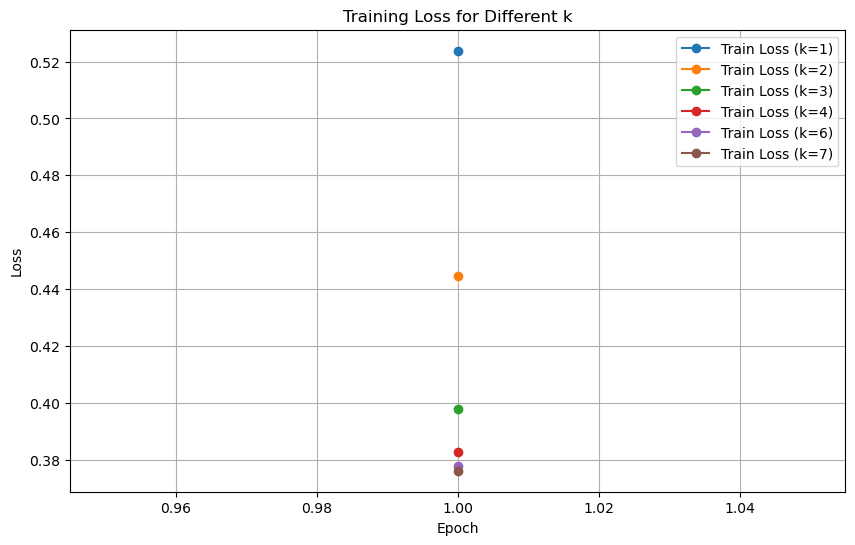

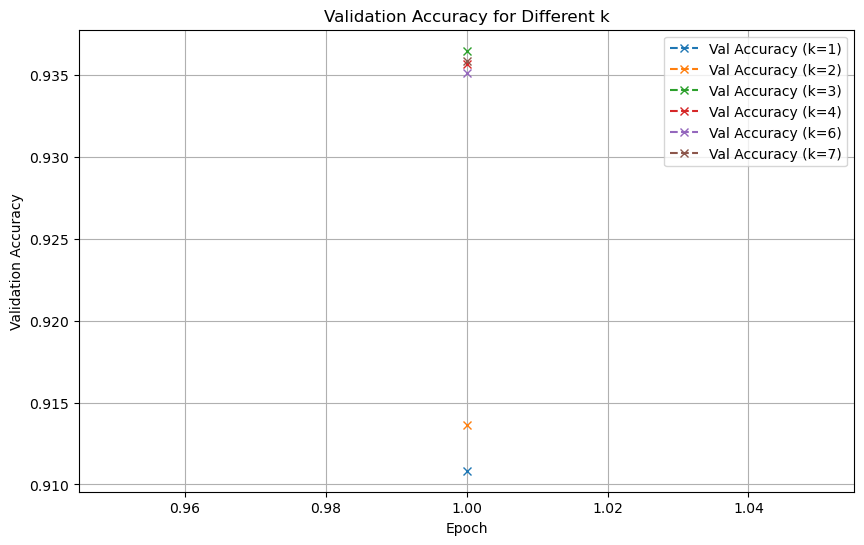

In [56]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import copy
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Set up the device.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ------------------------------
# Custom Autograd Function: Differentiable Knapsack Layer
# ------------------------------
class KnapsackLayerFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, c, k, epsilon, m):
        batch_size, num_learners = c.shape
        b = torch.zeros_like(c)
        _, topk_indices = torch.topk(c, k, dim=1)
        b.scatter_(1, topk_indices, 1.0)
        
        ctx.save_for_backward(c, b)
        ctx.k = k
        ctx.epsilon = epsilon
        ctx.m = m
        return b

    @staticmethod
    def backward(ctx, grad_output):
        c, b = ctx.saved_tensors
        k = ctx.k
        epsilon = ctx.epsilon
        m = ctx.m
        batch_size, num_learners = c.shape
        
        grad_est = torch.zeros_like(c)
        mask_total = torch.zeros_like(c)
        for i in range(m):
            z = torch.randn_like(c)
            c_perturbed = c + epsilon * z
            b_perturbed = torch.zeros_like(c)
            _, topk_indices = torch.topk(c_perturbed, k, dim=1)
            b_perturbed.scatter_(1, topk_indices, 1.0)
            mask_total += b_perturbed
            grad_est += b_perturbed * z  
        grad_est /= m
        avg_mask = mask_total / m
        
        # Uncomment for debugging:
        # print("Differentiable (avg) binary mask (first sample):", avg_mask[0])
        # print("Knapsack layer gradient estimate (first sample):", grad_est[0])
        # print("Knapsack layer gradient norm:", grad_est.norm().item())
        
        grad_input = grad_output * grad_est
        return grad_input, None, None, None

def differentiable_knapsack_layer(c, k, epsilon=0.1, m=10):
    return KnapsackLayerFunction.apply(c, k, epsilon, m)

# ------------------------------
# Selection Network Definition
# ------------------------------
class SelectionNetwork(nn.Module):
    def __init__(self, input_size, num_learners):
        super(SelectionNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, num_learners)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        scores = self.fc2(x)
        return scores

# ------------------------------
# Ensemble Forward Function
# ------------------------------
def ensemble_forward(selection_net, X, base_predictions, k, epsilon=0.1, m=10):
    c = selection_net(X)
    c_norm = F.normalize(c, p=2, dim=1)
    mask = differentiable_knapsack_layer(c_norm, k, epsilon, m)
    mask_expanded = mask.unsqueeze(-1)
    masked_predictions = base_predictions * mask_expanded
    summed_predictions = masked_predictions.sum(dim=1)
    final_preds = F.softmax(summed_predictions, dim=1)
    return final_preds

# ------------------------------
# Helper: Get Base Learners' Predictions
# ------------------------------
def get_base_predictions(X, base_learners):
    preds = []
    for name, model in base_learners.items():
        p = model.predict_proba(X)
        preds.append(p)
    preds = np.array(preds)
    return np.transpose(preds, (1, 0, 2))

# ------------------------------
# Training Function with Loss Recording and Saving Best Model Based on Validation Accuracy
# ------------------------------
def train_selection_net_record_losses(selection_net, base_learners, X_train, y_train, X_val, y_val, 
                                       num_epochs=10, k=2, epsilon=0.1, m=10, batch_size=1):
    # Convert training and validation data to tensors and move them to device.
    X_train_tensor = torch.tensor(X_train.values if hasattr(X_train, 'values') else X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train.values if hasattr(y_train, 'values') else y_train, dtype=torch.long).to(device)
    
    X_val_tensor = torch.tensor(X_val.values if hasattr(X_val, 'values') else X_val, dtype=torch.float32).to(device)
    y_val_tensor = torch.tensor(y_val.values if hasattr(y_val, 'values') else y_val, dtype=torch.long).to(device)
    
    optimizer = optim.Adam(selection_net.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    
    # Precompute base predictions and move them to device.
    base_preds_np = get_base_predictions(X_train, base_learners)
    base_preds_tensor = torch.tensor(base_preds_np, dtype=torch.float32).to(device)
    
    base_preds_np_val = get_base_predictions(X_val, base_learners)
    base_preds_tensor_val = torch.tensor(base_preds_np_val, dtype=torch.float32).to(device)
    
    num_samples = X_train_tensor.size(0)
    train_losses = []
    val_accuracies = []
    
    best_val_accuracy = 0.0
    best_state = None
    
    for epoch in range(num_epochs):
        permutation = torch.randperm(num_samples)
        epoch_loss = 0.0
        
        selection_net.train()
        for i in range(0, num_samples, batch_size):
            optimizer.zero_grad()
            indices = permutation[i:i+batch_size]
            X_batch = X_train_tensor[indices]
            y_batch = y_train_tensor[indices]
            base_preds_batch = base_preds_tensor[indices]
            
            ensemble_probs = ensemble_forward(selection_net, X_batch, base_preds_batch, k, epsilon, m)
            loss = criterion(ensemble_probs, y_batch)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item() * X_batch.size(0)
        
        avg_train_loss = epoch_loss / num_samples
        train_losses.append(avg_train_loss)
        
        # Evaluate on validation set
        selection_net.eval()
        with torch.no_grad():
            val_ensemble_probs = ensemble_forward(selection_net, X_val_tensor, base_preds_tensor_val, k, epsilon, m)
            _, predicted = torch.max(val_ensemble_probs, 1)
            val_accuracy = (predicted == y_val_tensor).float().mean().item()
            val_accuracies.append(val_accuracy)
        
        print(f"k={k}, Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
        
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_state = copy.deepcopy(selection_net.state_dict())
    
    return train_losses, val_accuracies, best_state

# ------------------------------
# Example Setup and Training for Multiple k Values
# ------------------------------
# Define your feature dimension, number of base learners, and number of classes.
feature_dim = 20      # Adjust as needed
num_learners = 10      
num_classes = 2       

ks = [1, 2, 3, 4, 6, 7,]
num_epochs = 1
epsilon = 0.1
m = 1000
batch_size = 512  # Adjust based on your dataset size

loss_results = {}
accuracy_results = {}
best_models = {}
overall_best_accuracy = 0.0
overall_best_model = None
overall_best_k = None

for k_val in ks:
    # Reinitialize a new selection network and move it to device.
    selection_net = SelectionNetwork(input_size=feature_dim, num_learners=num_learners).to(device)
    print(f"\nTraining for k = {k_val}")
    train_losses, val_accuracies, best_state = train_selection_net_record_losses(
        selection_net, specialized_learners, X_train, y_train, X_val, y_val,
        num_epochs=num_epochs, k=k_val, epsilon=epsilon, m=m, batch_size=batch_size
    )
    loss_results[k_val] = {'train': train_losses}
    accuracy_results[k_val] = {'val': val_accuracies}
    best_models[k_val] = best_state
    
    current_best_val_accuracy = max(val_accuracies)
    if current_best_val_accuracy > overall_best_accuracy:
        overall_best_accuracy = current_best_val_accuracy
        overall_best_model = best_state
        overall_best_k = k_val

print(f"\nOverall best validation accuracy: {overall_best_accuracy:.4f} achieved with k = {overall_best_k}")
# torch.save(overall_best_model, "best_selection_net_overall.pth")
# print("Best selection network across all k values saved to 'best_selection_net_overall.pth'.")

# Plot the Loss and Accuracy curves for each k.
plt.figure(figsize=(10,6))
for k_val in ks:
    epochs_range = range(1, num_epochs+1)
    plt.plot(epochs_range, loss_results[k_val]['train'], marker='o', label=f"Train Loss (k={k_val})")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss for Different k")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
for k_val in ks:
    epochs_range = range(1, num_epochs+1)
    plt.plot(epochs_range, accuracy_results[k_val]['val'], marker='x', linestyle='--', label=f"Val Accuracy (k={k_val})")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy for Different k")
plt.legend()
plt.grid(True)
plt.show()


Training Accuracy: 0.9472, F1 Score: 0.9454
Validation Accuracy: 0.9365, F1 Score: 0.9347


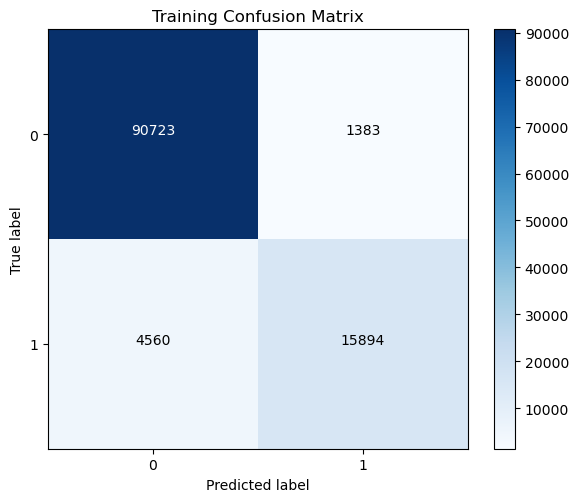

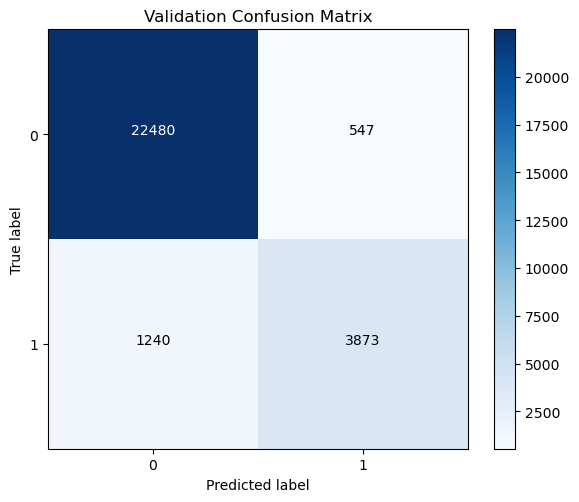

In [57]:
# ------------------------------
# Evaluation Function (GPU enabled)
# ------------------------------
def evaluate_ensemble(selection_net, base_learners, X, y, k, epsilon, m):
    X_tensor = torch.tensor(X.values if hasattr(X, 'values') else X, dtype=torch.float32).to(device)
    
    base_preds_np = get_base_predictions(X, base_learners)
    base_preds_tensor = torch.tensor(base_preds_np, dtype=torch.float32).to(device)
    
    ensemble_probs = ensemble_forward(selection_net, X_tensor, base_preds_tensor, k, epsilon, m)
    y_pred = ensemble_probs.argmax(dim=1).detach().cpu().numpy()
    y_true = y.values if hasattr(y, 'values') else np.array(y)
    
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    cm = confusion_matrix(y_true, y_pred)
    return acc, f1, cm, y_pred

# Instantiate a new SelectionNetwork and load the best overall model.
best_selection_net = SelectionNetwork(input_size=feature_dim, num_learners=num_learners).to(device)
best_selection_net.load_state_dict(overall_best_model)

# Evaluate on training data.
acc_train, f1_train, cm_train, _ = evaluate_ensemble(best_selection_net, specialized_learners, X_train, y_train, overall_best_k, epsilon, m)
print(f"Training Accuracy: {acc_train:.4f}, F1 Score: {f1_train:.4f}")

# Evaluate on validation data.
acc_val, f1_val, cm_val, _ = evaluate_ensemble(best_selection_net, specialized_learners, X_val, y_val, overall_best_k, epsilon, m)
print(f"Validation Accuracy: {acc_val:.4f}, F1 Score: {f1_val:.4f}")

def plot_confusion_matrix(cm, title='Confusion Matrix'):
    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(cm.shape[0])
    plt.xticks(tick_marks, tick_marks)
    plt.yticks(tick_marks, tick_marks)
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(cm_train, title='Training Confusion Matrix')
plot_confusion_matrix(cm_val, title='Validation Confusion Matrix')

### Creating a submission from the test data:

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# Assume 'device' is already defined as:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Helper function to generate predictions (GPU enabled) ---
def predict_ensemble(selection_net, base_learners, X, k, epsilon, m):
    # Convert input features to tensor and move to device.
    X_tensor = torch.tensor(X.values if hasattr(X, 'values') else X, dtype=torch.float32).to(device)
    # Get base predictions.
    base_preds_np = get_base_predictions(X, base_learners)
    base_preds_tensor = torch.tensor(base_preds_np, dtype=torch.float32).to(device)
    
    # Compute ensemble predictions.
    ensemble_probs = ensemble_forward(selection_net, X_tensor, base_preds_tensor, k, epsilon, m)
    y_pred = ensemble_probs.argmax(dim=1).detach().cpu().numpy()
    return y_pred

# --- Load the original test CSV to retrieve the id column ---
test_file = 'data/test.csv'
test_original = pd.read_csv(test_file)
ids = test_original['id']  # Assumes the test CSV has an "id" column

# --- Use the preprocessed test data (without id column) ---
# Assume 'test_data' is already preprocessed (via pre_processing function).
# If test_data was previously saved without the id, use it.
# For example, if you already did:
# test_data = pre_processing(test)
# then continue with test_data.

best_selection_net = SelectionNetwork(input_size=feature_dim, num_learners=num_learners).to(device)
best_selection_net.load_state_dict(overall_best_model)  # overall_best_model was saved earlier

# --- Generate predictions on the test set ---
y_test_pred = predict_ensemble(best_selection_net, specialized_learners, test_data, overall_best_k, epsilon, m)

# --- Create a submission DataFrame and save to CSV ---
submission_df = pd.DataFrame({"id": ids, "Depression": y_test_pred})
submission_df.to_csv("submission.csv", index=False)
print("Submission file saved as 'submission.csv'.")

Submission file saved as 'submission.csv'.
